In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error

register_matplotlib_converters()

##Загрузка датасета

In [14]:
import kagglehub
import os

path = kagglehub.dataset_download("uciml/electric-power-consumption-data-set")
file_path = os.path.join(path, 'household_power_consumption.txt')
df = pd.read_csv(file_path, sep=";", parse_dates={"Datetime": ["Date", "Time"]}, infer_datetime_format=True, na_values="?", dayfirst=True)
df.head()

<ipython-input-14-94b5f69c1acd>:6: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(file_path, sep=";", parse_dates={"Datetime": ["Date", "Time"]}, infer_datetime_format=True, na_values="?", dayfirst=True)
<ipython-input-14-94b5f69c1acd>:6: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(file_path, sep=";", parse_dates={"Datetime": ["Date", "Time"]}, infer_datetime_format=True, na_values="?", dayfirst=True)


,Datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Datetime               datetime64[ns]
 1   Global_active_power    float64       
 2   Global_reactive_power  float64       
 3   Voltage                float64       
 4   Global_intensity       float64       
 5   Sub_metering_1         float64       
 6   Sub_metering_2         float64       
 7   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB


##Предобработка

In [16]:
df.isna().sum()

,0
Datetime,0
Global_active_power,25979
Global_reactive_power,25979
Voltage,25979
Global_intensity,25979
Sub_metering_1,25979
Sub_metering_2,25979
Sub_metering_3,25979


In [17]:
df = df.dropna()
df = df.resample("h", on="Datetime").mean().reset_index()
df = df.interpolate(method="linear")

# Добавляем временные признаки
df["hour"] = df["Datetime"].dt.hour
df["dayofweek"] = df["Datetime"].dt.dayofweek
df["month"] = df["Datetime"].dt.month
df["year"] = df["Datetime"].dt.year
df["day"] = df["Datetime"].dt.day
df["day_of_year"] = df["Datetime"].dt.dayofyear
df = df.set_index("Datetime")

df = df.dropna()
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,dayofweek,month,year,day,day_of_year
Datetime,,,,,,,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111,17,5,12,2006,16,350
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667,18,5,12,2006,16,350
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333,19,5,12,2006,16,350
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333,20,5,12,2006,16,350
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667,21,5,12,2006,16,350


####Нормализация прогнозируемого ряда (Global_active_power)

In [18]:
# Нормализация прогнозируемого параметра
target_col = 'Global_active_power'
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[[target_col]])

####Создание временных окон для обучения

In [19]:
def create_dataset(data, window_size=24):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 168  # Используем 168 часов (1 неделя) для контекста
X, y = create_dataset(df_scaled, window_size)

####Разделение на train/test выборки

In [20]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

##Создание моделей

In [ ]:
GRUv1 = Sequential([
    GRU(64, return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.2),
    GRU(64),
    Dropout(0.2),
    Dense(1)
])
GRUv1.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
GRUv2 = Sequential([
    Bidirectional(GRU(128, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.2),
    GRU(64, return_sequences=True),
    BatchNormalization(),
    Dropout(0.2),
    GRU(32),
    Dense(1)
])
GRUv2.compile(optimizer='adam', loss='mse')

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

historyv1 = GRUv1.fit(X_train,
                    y_train,
                    epochs=30,
                    batch_size=32,
                    callbacks=[early_stop, lr_scheduler],
                    validation_data=(X_test, y_test),
                    verbose=1)


Epoch 1/30
861/861 ━━━━━━━━━━━━━━━━━━━━ 202s 230ms/step - loss: 0.0131 - val_loss: 0.0069 - learning_rate: 0.0010
Epoch 2/30
861/861 ━━━━━━━━━━━━━━━━━━━━ 194s 225ms/step - loss: 0.0103 - val_loss: 0.0068 - learning_rate: 0.0010
Epoch 3/30
861/861 ━━━━━━━━━━━━━━━━━━━━ 193s 224ms/step - loss: 0.0096 - val_loss: 0.0065 - learning_rate: 0.0010
Epoch 4/30
861/861 ━━━━━━━━━━━━━━━━━━━━ 202s 225ms/step - loss: 0.0092 - val_loss: 0.0068 - learning_rate: 0.0010
Epoch 5/30
861/861 ━━━━━━━━━━━━━━━━━━━━ 194s 226ms/step - loss: 0.0091 - val_loss: 0.0063 - learning_rate: 0.0010
Epoch 6/30
861/861 ━━━━━━━━━━━━━━━━━━━━ 202s 226ms/step - loss: 0.0091 - val_loss: 0.0063 - learning_rate: 0.0010
Epoch 7/30
861/861 ━━━━━━━━━━━━━━━━━━━━ 195s 226ms/step - loss: 0.0092 - val_loss: 0.0062 - learning_rate: 0.0010
Epoch 8/30
861/861 ━━━━━━━━━━━━━━━━━━━━ 201s 226ms/step - loss: 0.0087 - val_loss: 0.0064 - learning_rate: 0.0010
Epoch 9/30
861/861 ━━━━━━━━━━━━━━━━━━━━ 204s 228ms/step - loss: 0.0087 - val_loss: 0.006

In [ ]:
historyv2 = GRUv2.fit(X_train,
                    y_train,
                    epochs=30,
                    batch_size=32,
                    callbacks=[early_stop, lr_scheduler],
                    validation_data=(X_test, y_test),
                    verbose=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step 

Метрики:
MSE: 0.164
MAE: 0.292
RMSE: 0.405
R²: 0.654
MAPE: 0.376


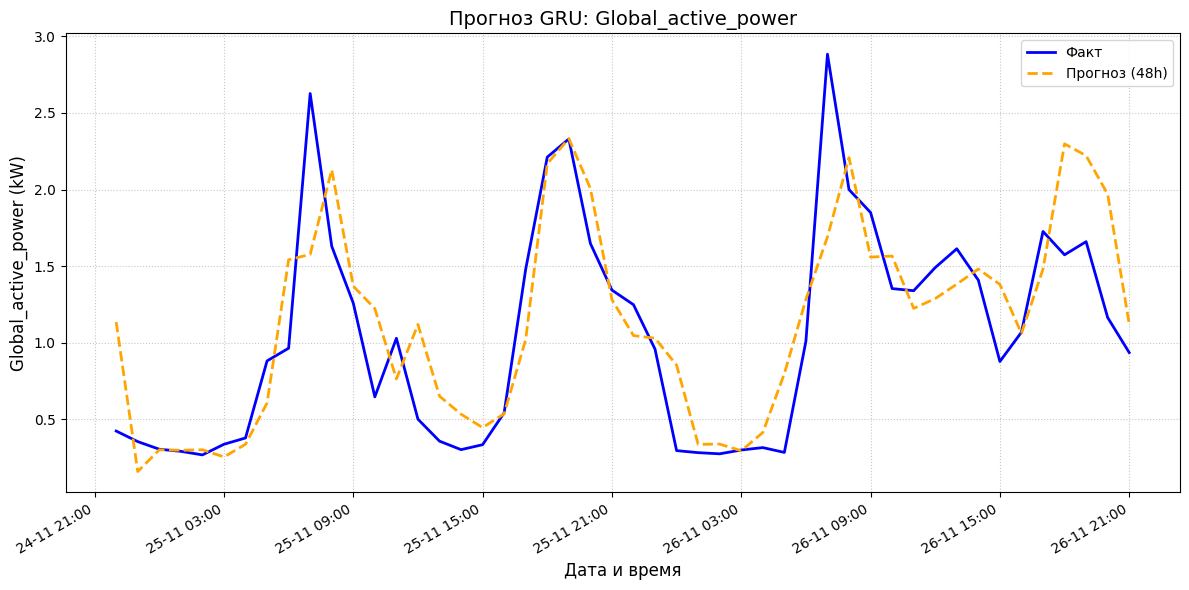

In [ ]:
real_data = scaler.inverse_transform(y_test[-48:].reshape(-1, 1))
timestamps = df.index[-len(y_test):][-48:]  # Временные метки для реальных данных

# Делаем прогноз на те же даты, что и реальные данные
forecast_scaled = GRUv1.predict(X_test[-48:])  # Прогноз для последних 48 часов
forecast_data = scaler.inverse_transform(forecast_scaled)

mse = mean_squared_error(real_data, forecast_data)
mae = mean_absolute_error(real_data, forecast_data)
rmse = np.sqrt(mse)
r2 = r2_score(real_data, forecast_data)
mape = mean_absolute_percentage_error(real_data, forecast_data)
print(f"\nМетрики:")
print(f"MSE: {mse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")
print(f"MAPE: {mape:.3f}")


# Настройка графика
plt.figure(figsize=(12, 6))
plt.plot(timestamps, real_data, label='Факт', linewidth=2, color='blue')
plt.plot(timestamps, forecast_data, label='Прогноз (48h)', linewidth=2, color='orange', linestyle='--')

# Форматирование оси X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))
plt.gcf().autofmt_xdate()


# Дополнительные элементы
plt.title("Прогноз GRU: Global_active_power", fontsize=14)
plt.xlabel("Дата и время", fontsize=12)
plt.ylabel("Global_active_power (kW)", fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

# Оптимизация параметров с Optuna

In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 7.5 MB/s eta 0:00:00


In [3]:
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.optimizers import Adam, RMSprop

In [4]:
import kagglehub
import os

path = kagglehub.dataset_download("uciml/electric-power-consumption-data-set")
file_path = os.path.join(path, 'household_power_consumption.txt')
df = pd.read_csv(file_path, sep=";", parse_dates={"Datetime": ["Date", "Time"]}, infer_datetime_format=True, na_values="?", dayfirst=True)
df.head()

<ipython-input-4-94b5f69c1acd>:6: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(file_path, sep=";", parse_dates={"Datetime": ["Date", "Time"]}, infer_datetime_format=True, na_values="?", dayfirst=True)
<ipython-input-4-94b5f69c1acd>:6: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(file_path, sep=";", parse_dates={"Datetime": ["Date", "Time"]}, infer_datetime_format=True, na_values="?", dayfirst=True)


,Datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [5]:
df = df.dropna()
df = df.resample("h", on="Datetime").mean().reset_index()
df = df.interpolate(method="linear")

# Добавляем временные признаки
df["hour"] = df["Datetime"].dt.hour
df["dayofweek"] = df["Datetime"].dt.dayofweek
df["month"] = df["Datetime"].dt.month
df["year"] = df["Datetime"].dt.year
df["day"] = df["Datetime"].dt.day
df["day_of_year"] = df["Datetime"].dt.dayofyear
df = df.set_index("Datetime")

df = df.dropna()
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,dayofweek,month,year,day,day_of_year
Datetime,,,,,,,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111,17,5,12,2006,16,350
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667,18,5,12,2006,16,350
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333,19,5,12,2006,16,350
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333,20,5,12,2006,16,350
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667,21,5,12,2006,16,350


In [6]:
# Нормализация прогнозируемого параметра
target_col = 'Global_active_power'
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[[target_col]])

In [7]:
def create_dataset(data, window_size=24):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 168  # Используем 168 часов (1 неделя) для контекста
X, y = create_dataset(df_scaled, window_size)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

def build_model(trial):
    model = Sequential()

    # Гиперпараметры
    n_layers = trial.suggest_int("n_layers", 1, 3)
    for i in range(n_layers):
        return_seq = i < n_layers - 1
        units = trial.suggest_int(f"units_l{i}", 32, 256, step=32)
        dropout = trial.suggest_float(f"dropout_l{i}", 0.1, 0.3)
        model.add(GRU(units, return_sequences=return_seq, input_shape=(X.shape[1], X.shape[2]) if i == 0 else None))
        model.add(Dropout(dropout))

    model.add(Dense(y.shape[1]))
    learning_rate = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["adam", "rmsprop"])
    optimizer = Adam(learning_rate=learning_rate) if optimizer_name == "adam" else RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
    return model

In [ ]:
def objective(trial):
    model = build_model(trial)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)

    history = model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=trial.suggest_categorical("batch_size", [16, 32, 64]),
        validation_data=(X_val, y_val),
        callbacks=[early_stop],
        verbose=0
    )

    val_loss = min(history.history["val_loss"])
    return val_loss

# Запускаем Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

# Лучшая модель
print("Лучшая конфигурация:")
print(study.best_params)

[I 2025-04-21 09:53:22,672] A new study created in memory with name: no-name-f44215d9-4775-461b-92b8-abfb3b8a4cd5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-04-21 09:58:11,607] Trial 0 finished with value: 0.005830510053783655 and parameters: {'n_layers': 2, 'units_l0': 64, 'dropout_l0': 0.16932292952824846, 'units_l1': 192, 'dropout_l1': 0.23293627397779137, 'lr': 0.0003222831781736782, 'optimizer': 'adam', 'batch_size': 64}. Best is trial 0 with value: 0.005830510053783655.
[W 2025-04-21 10:00:05,582] Trial 1 failed with parameters: {'n_layers': 1, 'units_l0': 256, 'dropout_l0': 0.14167386880540472, 'lr': 0.003025771720555994, 'optimizer': 'adam', 'batch_size': 16} because of the following error: The value nan is not acceptable.
[W 2025-

In [ ]:
!pip install optuna[visualization]

In [ ]:
import optuna.visualization as vis

# 1. История потерь (val_loss по эпохам)
fig1 = vis.plot_optimization_history(study)
fig1.show()

# 2. Важность гиперпараметров
fig2 = vis.plot_param_importances(study)
fig2.show()

In [8]:
params = {'n_layers': 2, 'units_l0': 64, 'dropout_l0': 0.16932292952824846, 'units_l1': 192, 'dropout_l1': 0.23293627397779137, 'lr': 0.0003222831781736782, 'optimizer': 'adam', 'batch_size': 64}
def build_model(params):
    model = Sequential()

    for i in range(params['n_layers']):
        return_seq = i < params['n_layers'] - 1
        units = params[f'units_l{i}']
        dropout = params[f'dropout_l{i}']
        model.add(GRU(units, return_sequences=return_seq, input_shape=(X.shape[1], X.shape[2]) if i == 0 else None))
        model.add(Dropout(dropout))

    model.add(Dense(y.shape[1]))
    optimizer = Adam(learning_rate=params['lr']) if params['optimizer'] == 'adam' else RMSprop(learning_rate=params['lr'])
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [11]:
best_model = build_model(params)

history = best_model.fit(
    X, y,
    epochs=50,
    batch_size=params['batch_size'],
    validation_split=0.2,
    callbacks=[
        EarlyStopping(patience=10, restore_best_weights=True),
        ReduceLROnPlateau(patience=5, factor=0.5)
    ],
    verbose=1
)

Epoch 1/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 313s 713ms/step - loss: 0.0141 - mae: 0.0894 - val_loss: 0.0071 - val_mae: 0.0578 - learning_rate: 3.2228e-04
Epoch 2/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 316s 700ms/step - loss: 0.0101 - mae: 0.0716 - val_loss: 0.0070 - val_mae: 0.0604 - learning_rate: 3.2228e-04
Epoch 3/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 304s 659ms/step - loss: 0.0100 - mae: 0.0711 - val_loss: 0.0073 - val_mae: 0.0654 - learning_rate: 3.2228e-04
Epoch 4/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 323s 660ms/step - loss: 0.0100 - mae: 0.0710 - val_loss: 0.0070 - val_mae: 0.0605 - learning_rate: 3.2228e-04
Epoch 5/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 323s 662ms/step - loss: 0.0097 - mae: 0.0698 - val_loss: 0.0068 - val_mae: 0.0586 - learning_rate: 3.2228e-04
Epoch 6/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 320s 659ms/step - loss: 0.0094 - mae: 0.0680 - val_loss: 0.0066 - val_mae: 0.0547 - learning_rate: 3.2228e-04
Epoch 7/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 285s 662ms/step - loss: 0.0093 - mae: 0.0677 - val_loss: 0.0

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 475ms/step

Метрики:
MSE: 0.167
MAE: 0.284
RMSE: 0.409
R²: 0.647
MAPE: 0.344


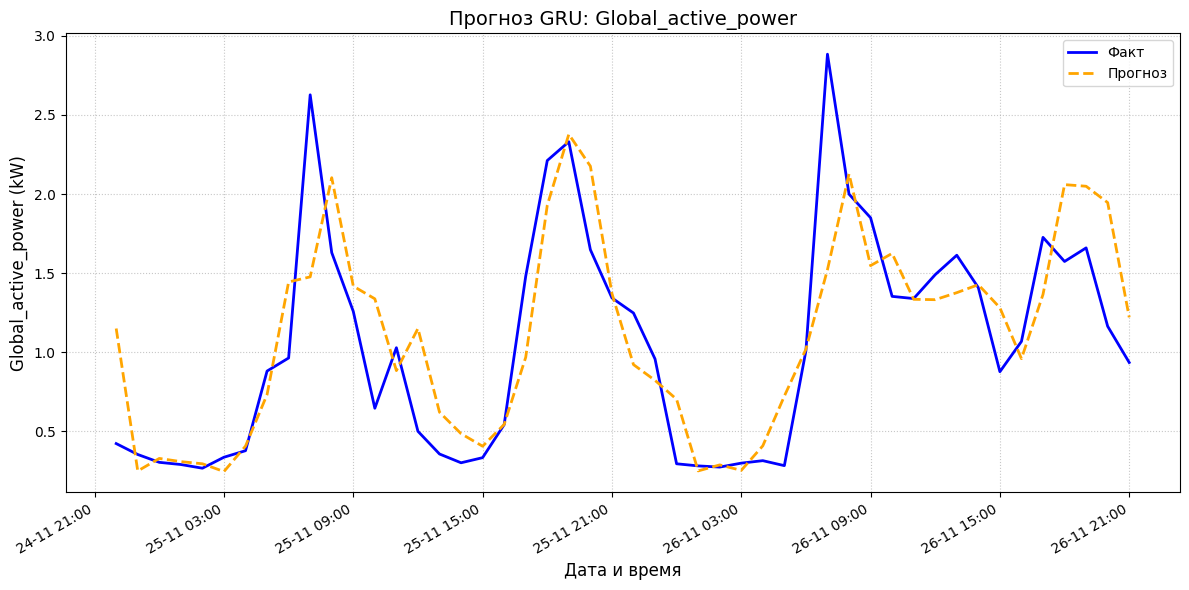

In [21]:
real_data = scaler.inverse_transform(y_test[-48:].reshape(-1, 1))
timestamps = df.index[-len(y_test):][-48:]

forecast_scaled = best_model.predict(X_test[-48:])
forecast_data = scaler.inverse_transform(forecast_scaled)

mse = mean_squared_error(real_data, forecast_data)
mae = mean_absolute_error(real_data, forecast_data)
rmse = np.sqrt(mse)
r2 = r2_score(real_data, forecast_data)
mape = mean_absolute_percentage_error(real_data, forecast_data)
print(f"\nМетрики:")
print(f"MSE: {mse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")
print(f"MAPE: {mape:.3f}")


# Настройка графика
plt.figure(figsize=(12, 6))
plt.plot(timestamps, real_data, label='Факт', linewidth=2, color='blue')
plt.plot(timestamps, forecast_data, label='Прогноз', linewidth=2, color='orange', linestyle='--')

# Форматирование оси X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))
plt.gcf().autofmt_xdate()


# Дополнительные элементы
plt.title("Прогноз GRU: Global_active_power", fontsize=14)
plt.xlabel("Дата и время", fontsize=12)
plt.ylabel("Global_active_power (kW)", fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()